In [4]:
import numpy as np
import cv2 as cv
from matplotlib import pyplot as plt
from google.colab.patches import cv_imshow

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


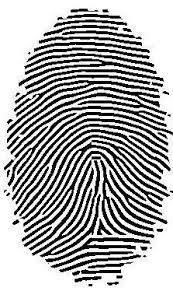

In [6]:
path="/content/drive/My Drive/CS21B2028/BiometricsProject/fingerprint0.jpg"
image=cv.imread(path)
cv_imshow(image)

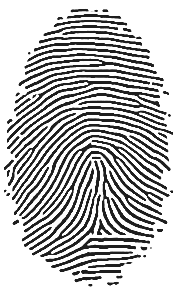

In [7]:
# Convert the image to grayscale
gray_image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

# Remove noise using Gaussian blur
blurred_image = cv.GaussianBlur(gray_image, (5, 5), 0)

# Sharpen the image using unsharp masking
sharpness = cv.filter2D(blurred_image, -1, np.array([[-1, -1, -1],
                                                    [-1,  9, -1],
                                                    [-1, -1, -1]]))

# Increase brightness by adjusting intensity
brightened_image = cv.convertScaleAbs(sharpness, alpha=1.5, beta=30)

# Display the enhanced image
cv_imshow(brightened_image)

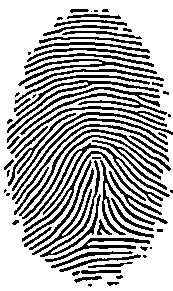

In [8]:
# Read the enhanced image
enhanced_image = brightened_image

# Define block size
W = 16

# Calculate the number of rows and columns
rows, cols = enhanced_image.shape

# Create an empty binary image
binary_image = np.zeros_like(enhanced_image)

# Iterate through the image in blocks and binarize
for i in range(0, rows, W):
    for j in range(0, cols, W):
        block = enhanced_image[i:i+W, j:j+W]
        block_mean = np.mean(block)
        binary_image[i:i+W, j:j+W] = np.where(block >= block_mean, 255, 0)

# Display the binarized image
cv_imshow(binary_image)

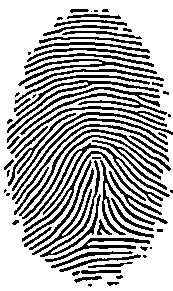

In [9]:
def zhang_suen_thinning(binary_image):
    # Make a copy of the binary image
    thinning_image = binary_image.copy()

    # Define the 8 neighboring pixels
    neighbors = [(1, 0), (1, -1), (0, -1), (-1, -1),
                 (-1, 0), (-1, 1), (0, 1), (1, 1)]

    while True:
        # Step 1
        to_delete = []
        for i in range(1, thinning_image.shape[0] - 1):
            for j in range(1, thinning_image.shape[1] - 1):
                if thinning_image[i, j] == 0:
                    continue
                p2 = [thinning_image[i + neighbors[k][0], j + neighbors[k][1]] for k in range(8)]
                p2.append(thinning_image[i + 1, j])
                p2.append(thinning_image[i - 1, j])
                if 2 <= sum(p2) <= 6:
                    p1 = [1 if p2[k] == 0 else 0 for k in range(8)]
                    p1.append(1 if thinning_image[i + 1, j] == 0 else 0)
                    p1.append(1 if thinning_image[i - 1, j] == 0 else 0)
                    if sum(p1) == 1:
                        if p2[0] * p2[2] * p2[4] == 0 and p2[2] * p2[4] * p2[6] == 0:
                            to_delete.append((i, j))

        for i, j in to_delete:
            thinning_image[i, j] = 0

        # Step 2
        to_delete.clear()
        for i in range(1, thinning_image.shape[0] - 1):
            for j in range(1, thinning_image.shape[1] - 1):
                if thinning_image[i, j] == 0:
                    continue
                p2 = [thinning_image[i + neighbors[k][0], j + neighbors[k][1]] for k in range(8)]
                p2.append(thinning_image[i, j + 1])
                p2.append(thinning_image[i, j - 1])
                if 2 <= sum(p2) <= 6:
                    p1 = [1 if p2[k] == 0 else 0 for k in range(8)]
                    p1.append(1 if thinning_image[i, j + 1] == 0 else 0)
                    p1.append(1 if thinning_image[i, j - 1] == 0 else 0)
                    if sum(p1) == 1:
                        if p2[0] * p2[2] * p2[6] == 0 and p2[0] * p2[4] * p2[6] == 0:
                            to_delete.append((i, j))

        for i, j in to_delete:
            thinning_image[i, j] = 0

        # Check for convergence
        if not to_delete:
            break

    return thinning_image

# Read the binary image
binary_image = binary_image  # Assuming you already have the binary image

# Thin the binary image using Zhang-Suen thinning algorithm
thinned_image = zhang_suen_thinning(binary_image)

# Display the thinned image
cv_imshow(thinned_image)


<ipython-input-10-7844c7a03ca3>:12: RuntimeWarning: invalid value encountered in sqrt
  enhanced_image = np.sqrt((desired_variance / variance) * (image - mean)) + desired_mean
<ipython-input-10-7844c7a03ca3>:13: RuntimeWarning: invalid value encountered in cast
  enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)


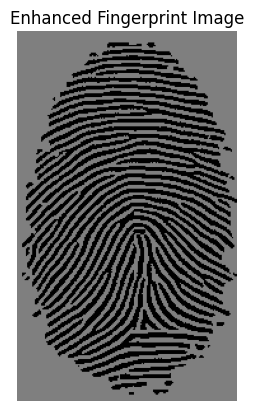

In [10]:
# Image Enhancement
def enhance_image(image):
    # Calculate mean and variance of the image
    mean = np.mean(image)
    variance = np.var(image)

    # Define desired mean and variance values
    desired_mean = 127  # Adjust as needed
    desired_variance = 100  # Adjust as needed

    # Normalize the image
    enhanced_image = np.sqrt((desired_variance / variance) * (image - mean)) + desired_mean
    enhanced_image = np.clip(enhanced_image, 0, 255).astype(np.uint8)

    return enhanced_image

# Enhance the uploaded image
enhanced_image = enhance_image(image)

# Display the enhanced image
plt.imshow(enhanced_image, cmap='gray')
plt.axis('off')
plt.title('Enhanced Fingerprint Image')
plt.show()


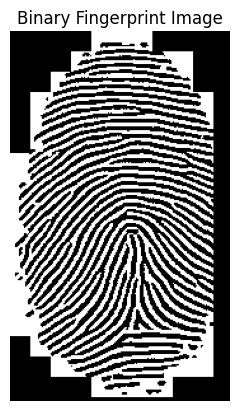

In [11]:
# Image Binarization
def binarize_image(image, block_size):
    # Convert image to grayscale if it's a color image
    if len(image.shape) == 3:
        image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)

    # Divide the image into non-overlapping blocks
    h, w = image.shape
    num_blocks_h = h // block_size
    num_blocks_w = w // block_size

    # Initialize binary image
    binary_image = np.zeros_like(image, dtype=np.uint8)

    for i in range(num_blocks_h):
        for j in range(num_blocks_w):
            # Calculate mean intensity for each block
            block = image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size]
            block_mean = np.mean(block)

            # Threshold the block to obtain binary representation
            binary_image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] = (
                image[i*block_size:(i+1)*block_size, j*block_size:(j+1)*block_size] > block_mean
            ) * 255

    return binary_image

# Define block size for binarization (adjust as needed)
block_size = 16

# Binarize the enhanced image
binary_image = binarize_image(enhanced_image, block_size)

# Display the binary image
plt.imshow(binary_image, cmap='gray')
plt.axis('off')
plt.title('Binary Fingerprint Image')
plt.show()


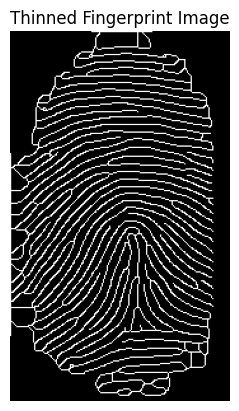

In [12]:
# Image Thinning
def thin_image(image):
    # Apply Zhang-Suen thinning algorithm
    skeleton = cv.ximgproc.thinning(image)

    return skeleton

# Thin the binary image
thinned_image = thin_image(binary_image)

# Display the thinned image
plt.imshow(thinned_image, cmap='gray')
plt.axis('off')
plt.title('Thinned Fingerprint Image')
plt.show()


In [ ]:
# import numpy as np
# import cv2
# from google.colab.patches import cv2_imshow

# def detect_minutiae(image):
#     # Define neighborhood for minutiae detection
#     neighborhood = np.array([[1, 1, 1],
#                              [1, 0, 1],
#                              [1, 1, 1]], dtype=np.uint8)

#     # Perform dilation to identify ridge pixels
#     ridge_pixels = cv2.dilate(image, neighborhood)

#     # Find ridge endings and bifurcations using hit-or-miss transform
#     endings_kernel = np.array([[1, 1, 1],
#                                [1, 0, 1],
#                                [0, 0, 0]], dtype=np.uint8)
#     bifurcations_kernel = np.array([[0, 1, 0],
#                                     [1, 0, 1],
#                                     [0, 1, 0]], dtype=np.uint8)
#     ridge_endings = cv2.morphologyEx(image, cv2.MORPH_HITMISS, endings_kernel)
#     bifurcations = cv2.morphologyEx(image, cv2.MORPH_HITMISS, bifurcations_kernel)

#     # Get coordinates of ridge endings and bifurcations
#     endings_y, endings_x = np.where(ridge_endings == 255)
#     bifurcations_y, bifurcations_x = np.where(bifurcations == 255)

#     # Create a list to store minutiae points and their types
#     minutiae_info = []

#     # Add ridge endings to minutiae list
#     for x, y in zip(endings_x, endings_y):
#         minutiae_info.append((x, y, 'Ridge Ending'))

#     # Add bifurcations to minutiae list
#     for x, y in zip(bifurcations_x, bifurcations_y):
#         minutiae_info.append((x, y, 'Bifurcation'))

#     # Print number of detected minutiae points
#     print("Number of Detected Minutiae Points:", len(minutiae_info))

#     return minutiae_info

# # Function to display minutiae points on the fingerprint image
# def display_minutiae(image, minutiae_info):
#     # Make a copy of the image to draw on
#     image_with_minutiae = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

#     # Define colors for different types of minutiae
#     ridge_color = (0, 255, 0)  # Green
#     bifurcation_color = (0, 0, 255)  # Red

#     # Draw markers for each minutiae point and label them with their type
#     for minutia in minutiae_info:
#         x, y, minutia_type = minutia
#         color = ridge_color if minutia_type == 'Ridge Ending' else bifurcation_color
#         cv2.circle(image_with_minutiae, (x, y), 5, color, -1)
#         cv2.putText(image_with_minutiae, minutia_type, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

#         # Print minutiae point and its type
#         print("Minutiae Point: ({}, {}), Type: {}".format(x, y, minutia_type))

#     # Display the image with marked minutiae points
#     cv2_imshow(image_with_minutiae)

# # Assuming 'thinned_image' is your preprocessed fingerprint image
# minutiae_info = detect_minutiae(thinned_image)

# # Display the fingerprint image with marked minutiae points
# display_minutiae(thinned_image, minutiae_info)


Number of Detected Minutiae Points: 71
Minutiae Points:
(65, 0, 'Ridge Ending')
(66, 0, 'Ridge Ending')
(67, 0, 'Ridge Ending')
(68, 0, 'Ridge Ending')
(69, 0, 'Ridge Ending')
(70, 0, 'Ridge Ending')
(71, 0, 'Ridge Ending')
(72, 0, 'Ridge Ending')
(73, 0, 'Ridge Ending')
(74, 0, 'Ridge Ending')
(75, 0, 'Ridge Ending')
(76, 0, 'Ridge Ending')
(77, 0, 'Ridge Ending')
(78, 0, 'Ridge Ending')
(79, 0, 'Ridge Ending')
(80, 0, 'Ridge Ending')
(81, 0, 'Ridge Ending')
(82, 0, 'Ridge Ending')
(83, 0, 'Ridge Ending')
(84, 0, 'Ridge Ending')
(85, 0, 'Ridge Ending')
(86, 0, 'Ridge Ending')
(87, 0, 'Ridge Ending')
(88, 0, 'Ridge Ending')
(89, 0, 'Ridge Ending')
(90, 0, 'Ridge Ending')
(91, 0, 'Ridge Ending')
(92, 0, 'Ridge Ending')
(93, 0, 'Ridge Ending')
(94, 0, 'Ridge Ending')
(95, 0, 'Ridge Ending')
(96, 0, 'Ridge Ending')
(97, 0, 'Ridge Ending')
(98, 0, 'Ridge Ending')
(99, 0, 'Ridge Ending')
(100, 0, 'Ridge Ending')
(101, 0, 'Ridge Ending')
(102, 0, 'Ridge Ending')
(103, 0, 'Ridge Ending')
(104

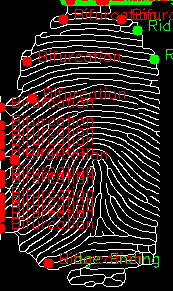

In [15]:
def detect_minutiae(image):
    # Define neighborhood for minutiae detection
    neighborhood = np.array([[1, 1, 1],
                             [1, 0, 1],
                             [1, 1, 1]], dtype=np.uint8)

    # Perform dilation to identify ridge pixels
    ridge_pixels = cv2.dilate(image, neighborhood)

    # Find ridge endings and bifurcations using hit-or-miss transform
    endings_kernel = np.array([[1, 1, 1],
                               [1, 0, 1],
                               [0, 0, 0]], dtype=np.uint8)
    bifurcations_kernel = np.array([[0, 1, 0],
                                    [1, 0, 1],
                                    [0, 1, 0]], dtype=np.uint8)
    ridge_endings = cv2.morphologyEx(image, cv2.MORPH_HITMISS, endings_kernel)
    bifurcations = cv2.morphologyEx(image, cv2.MORPH_HITMISS, bifurcations_kernel)

    # Get coordinates of ridge endings and bifurcations
    endings_y, endings_x = np.where(ridge_endings == 255)
    bifurcations_y, bifurcations_x = np.where(bifurcations == 255)

    # Create a list to store minutiae points
    minutiae_points = []

    # Add ridge endings to minutiae list
    for x, y in zip(endings_x, endings_y):
        minutiae_points.append((x, y, 'Ridge Ending'))

    # Add bifurcations to minutiae list
    for x, y in zip(bifurcations_x, bifurcations_y):
        minutiae_points.append((x, y, 'Bifurcation'))

    # Print number of detected minutiae points
    print("Number of Detected Minutiae Points:", len(minutiae_points))

    # Display minutiae points as an array
    print("Minutiae Points:")
    for minutia in minutiae_points:
        print(minutia)

    return minutiae_points

# Function to display minutiae points on the fingerprint image
def display_minutiae(image, minutiae_points):
    # Make a copy of the image to draw on
    image_with_minutiae = cv2.cvtColor(image, cv2.COLOR_GRAY2BGR)

    # Define colors for different types of minutiae
    ridge_color = (0, 255, 0)  # Green
    bifurcation_color = (0, 0, 255)  # Red

    # Draw markers for each minutiae point and label them with their type
    for minutia in minutiae_points:
        x, y, minutia_type = minutia
        color = ridge_color if minutia_type == 'Ridge Ending' else bifurcation_color
        cv2.circle(image_with_minutiae, (x, y), 5, color, -1)
        cv2.putText(image_with_minutiae, minutia_type, (x + 10, y), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 1)

    # Display the image with marked minutiae points
    cv2_imshow(image_with_minutiae)

# Assuming 'thinned_image' is your preprocessed fingerprint image
minutiae_points = detect_minutiae(thinned_image)

# Display the fingerprint image with marked minutiae points
display_minutiae(thinned_image, minutiae_points)

In [ ]:
# import hashlib

# # Sample minutiae points (for demonstration purposes)
# minutiae_points = [
#     {"x": 100, "y": 200, "type": "ridge ending"},
#     {"x": 150, "y": 250, "type": "bifurcation"},
#     # Add more minutiae points as needed
# ]

# def encode_minutiae(minutiae_points):
#     # Encode minutiae points into a string representation
#     encoded_minutiae = ""
#     for point in minutiae_points:
#         encoded_minutiae += f"{point['x']},{point['y']},{point['type']};"
#     return encoded_minutiae.encode('utf-8')

# def generate_key(minutiae_encoded):
#     # Use a cryptographic hash function to generate a key from the encoded minutiae
#     key = hashlib.sha256(minutiae_encoded).hexdigest()
#     return key

# # Example usage:
# encoded_minutiae = encode_minutiae(minutiae_points)
# key = generate_key(encoded_minutiae)

# print("Encoded Minutiae:", encoded_minutiae)
# print("Generated Key:", key)


In [19]:
import hashlib

def detect_minutiae(image):
    # Define neighborhood for minutiae detection
    neighborhood = np.array([[1, 1, 1],
                             [1, 0, 1],
                             [1, 1, 1]], dtype=np.uint8)

    # Perform dilation to identify ridge pixels
    ridge_pixels = cv2.dilate(image, neighborhood)

    # Find ridge endings and bifurcations using hit-or-miss transform
    endings_kernel = np.array([[1, 1, 1],
                               [1, 0, 1],
                               [0, 0, 0]], dtype=np.uint8)
    bifurcations_kernel = np.array([[0, 1, 0],
                                    [1, 0, 1],
                                    [0, 1, 0]], dtype=np.uint8)
    ridge_endings = cv2.morphologyEx(image, cv2.MORPH_HITMISS, endings_kernel)
    bifurcations = cv2.morphologyEx(image, cv2.MORPH_HITMISS, bifurcations_kernel)

    # Get coordinates of ridge endings and bifurcations
    endings_y, endings_x = np.where(ridge_endings == 255)
    bifurcations_y, bifurcations_x = np.where(bifurcations == 255)

    # Create a list to store minutiae points
    minutiae_points = []

    # Add ridge endings to minutiae list
    for x, y in zip(endings_x, endings_y):
        minutiae_points.append((x, y, 'Ridge Ending'))

    # Add bifurcations to minutiae list
    for x, y in zip(bifurcations_x, bifurcations_y):
        minutiae_points.append((x, y, 'Bifurcation'))

    return minutiae_points

def generate_key(minutiae_encoded):
    # Use a cryptographic hash function to generate a key from the encoded minutiae
    key = hashlib.sha256(minutiae_encoded).hexdigest()
    # Truncate the key to be no more than 10 digits
    key = key[:10]
    return key

# Assuming 'thinned_image' is your preprocessed fingerprint image
minutiae_points = detect_minutiae(thinned_image)

# Encode minutiae points into a string representation
minutiae_encoded = str(minutiae_points).encode('utf-8')

# Generate a cryptographic key from the encoded minutiae
key = generate_key(minutiae_encoded)

print("Generated Key:", key)

Generated Key: 7e7e4ff506
